In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import pathlib

In [2]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')

GPU is available
Number of available GPUs: 1
GPU 0: {'device_name': 'NVIDIA GeForce RTX 3060 Ti', 'compute_capability': (8, 6)}


In [3]:
import os
os.getcwd()

'd:\\Rice_Image_Dataset\\Code'

In [4]:
data_dir = 'd:\\Rice_Image_Dataset\\Dataset'
os.listdir(data_dir)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [5]:
tf.random.set_seed(42)

train_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'training', seed = 1, shuffle = True, batch_size = 64, image_size=(128,128))

test_data = keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.1, subset = 'validation', seed = 1, shuffle = True, batch_size = 64, image_size=(128,128))

Found 75000 files belonging to 5 classes.
Using 67500 files for training.
Found 75000 files belonging to 5 classes.
Using 7500 files for validation.


In [6]:
filenames = pathlib.Path(data_dir)
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

Arborio : 15000
Basmati : 15000
Ipsala : 15000
Jasmine : 15000
Karacadag : 15000


In [7]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy()

(1055, 118)

In [8]:
train_set = train_data.take(937)
val_set = train_data.skip(937)

In [9]:
train_set.cardinality().numpy(), val_set.cardinality().numpy()

(937, 118)

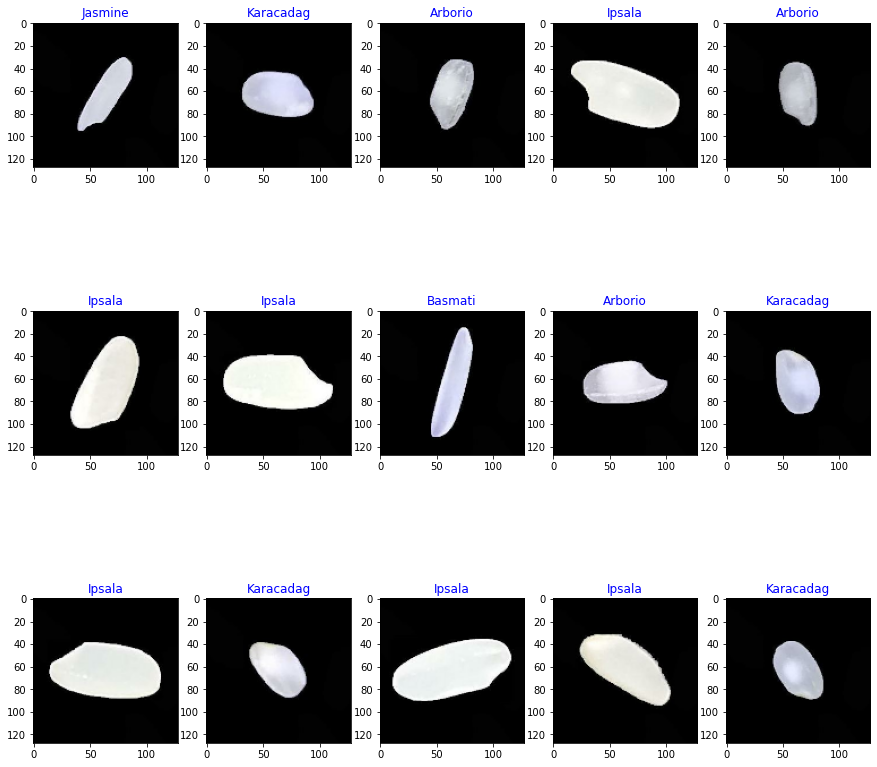

In [10]:
# print random images from the train set
plt.figure(figsize = (15, 15))
for images, labels in train_set.take(1):
    for i in range(15):
        index = random.randint(0, len(images))
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color= 'blue', fontsize= 12)
        plt.axis(True)
plt.show()

In [11]:
for images_batch, labels_batch in train_set:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(64, 128, 128, 3)
(64,)


# VGG16

In [24]:
from tensorflow.keras.applications import VGG16

In [25]:
vgg16Model = VGG16(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [26]:
vgg16Model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [27]:
vgg16Model.trainable = True

In [28]:
from tensorflow.keras import layers

In [29]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    vgg16Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [30]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [31]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 147s 152ms/step - loss: 0.0894 - accuracy: 0.9670 - val_loss: 0.0102 - val_accuracy: 0.9971
Epoch 2/15
937/937 [==============================] - 141s 151ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0061 - val_accuracy: 0.9983
Epoch 3/15
937/937 [==============================] - 142s 152ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0109 - val_accuracy: 0.9964
Epoch 4/15
937/937 [==============================] - 142s 151ms/step - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0071 - val_accuracy: 0.9977
Epoch 5/15
937/937 [==============================] - 142s 152ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0060 - val_accuracy: 0.9984
Epoch 6/15
937/937 [==============================] - 142s 152ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0084 - val_accuracy: 0.9972
Epoch 7/15
937/937 [==============================] - 142s 151ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0126 -

In [32]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [33]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\vgg16Model.h5')

In [34]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

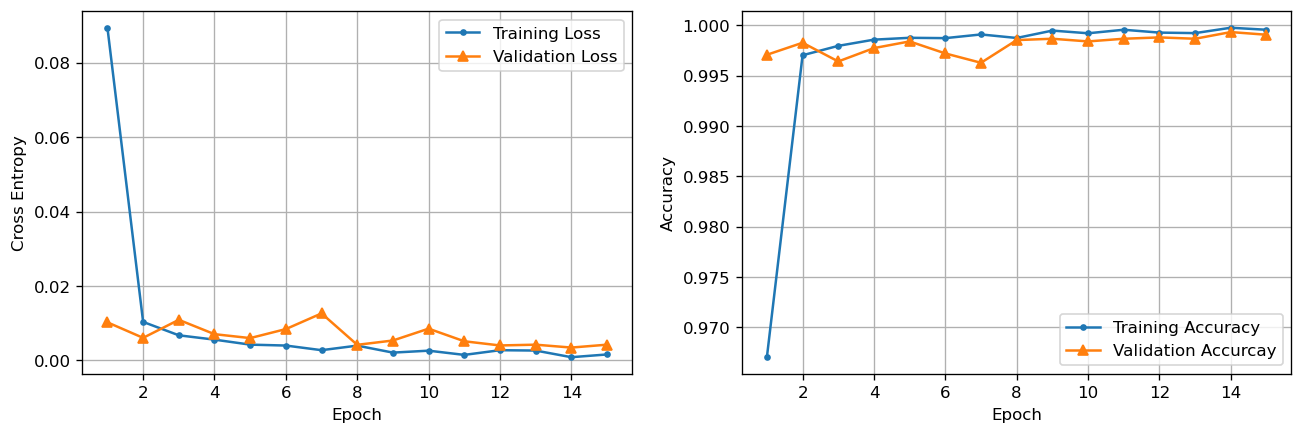

In [35]:
plot_training_curves(pd.DataFrame(history_2.history))

In [36]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)
        
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [37]:
from sklearn import metrics

In [38]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [39]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 6s 48ms/step - loss: 0.0021 - accuracy: 0.9995
Test Loss:  0.002075746888294816
Test Accuracy:  0.9994666576385498


In [40]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      1262
     Basmati       1.00      1.00      1.00      1275
      Ipsala       1.00      1.00      1.00      1309
     Jasmine       1.00      1.00      1.00      1298
   Karacadag       1.00      1.00      1.00      1256

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# VGG19

In [41]:
from tensorflow.keras.applications import VGG19

In [42]:
vgg19Model = VGG19(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [43]:
vgg19Model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [44]:
vgg19Model.trainable = True

In [45]:
from tensorflow.keras import layers

In [46]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    vgg19Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [47]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [48]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 162s 172ms/step - loss: 0.1096 - accuracy: 0.9586 - val_loss: 0.0075 - val_accuracy: 0.9975
Epoch 2/15
937/937 [==============================] - 162s 172ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0052 - val_accuracy: 0.9983
Epoch 3/15
937/937 [==============================] - 162s 173ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0076 - val_accuracy: 0.9980
Epoch 4/15
937/937 [==============================] - 162s 173ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0059 - val_accuracy: 0.9989
Epoch 5/15
937/937 [==============================] - 162s 173ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0043 - val_accuracy: 0.9988
Epoch 6/15
937/937 [==============================] - 162s 173ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0084 - val_accuracy: 0.9977
Epoch 7/15
937/937 [==============================] - 163s 173ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0063 -

In [49]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [50]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\vgg19Model.h5')

In [51]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

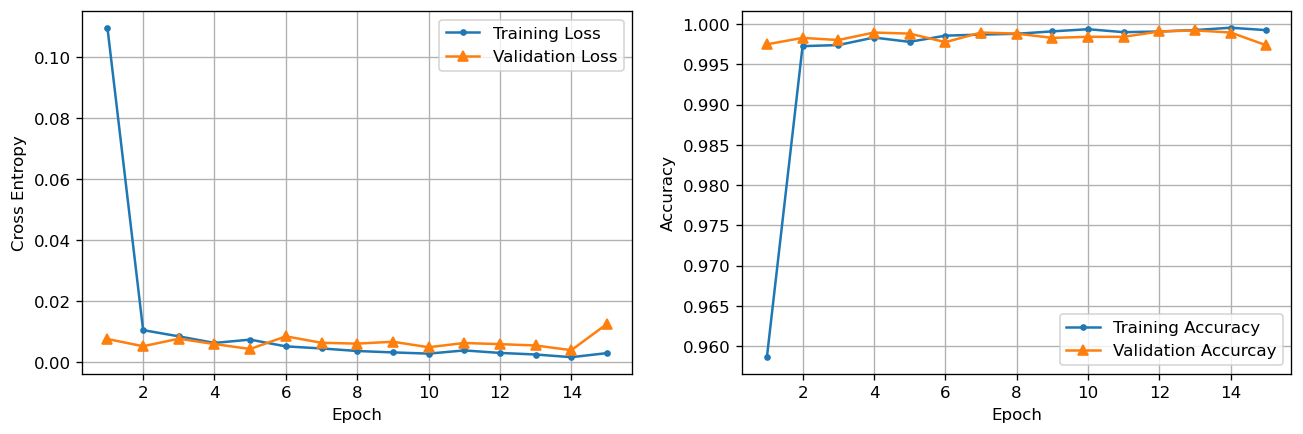

In [52]:
plot_training_curves(pd.DataFrame(history_2.history))

In [53]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [54]:
from sklearn import metrics

In [55]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [56]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 6s 51ms/step - loss: 0.0115 - accuracy: 0.9976
Test Loss:  0.01148889772593975
Test Accuracy:  0.9976000189781189


In [57]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       0.99      1.00      0.99      1256
     Basmati       1.00      1.00      1.00      1275
      Ipsala       1.00      1.00      1.00      1314
     Jasmine       1.00      1.00      1.00      1299
   Karacadag       1.00      0.99      0.99      1256

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# ResNet50V2

In [58]:
from tensorflow.keras.applications import ResNet50V2

In [59]:
resNet50V2Model = ResNet50V2(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

94683136/94668760 [==============================] - 54s 1us/step


In [60]:
resNet50V2Model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [61]:
resNet50V2Model.trainable = True

In [62]:
from tensorflow.keras import layers

In [63]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    resNet50V2Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [64]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [65]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 118s 120ms/step - loss: 0.1714 - accuracy: 0.9427 - val_loss: 0.0143 - val_accuracy: 0.9956
Epoch 2/15
937/937 [==============================] - 112s 119ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0135 - val_accuracy: 0.9973
Epoch 3/15
937/937 [==============================] - 112s 119ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.0096 - val_accuracy: 0.9975
Epoch 4/15
937/937 [==============================] - 112s 120ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0116 - val_accuracy: 0.9983
Epoch 5/15
937/937 [==============================] - 112s 120ms/step - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.0153 - val_accuracy: 0.9975
Epoch 6/15
937/937 [==============================] - 112s 120ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0099 - val_accuracy: 0.9980
Epoch 7/15
937/937 [==============================] - 112s 120ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0108 -

In [66]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [67]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\resNet50V2Model.h5')

c:\Users\Shuvashis\anaconda3\envs\FAIKA\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [68]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

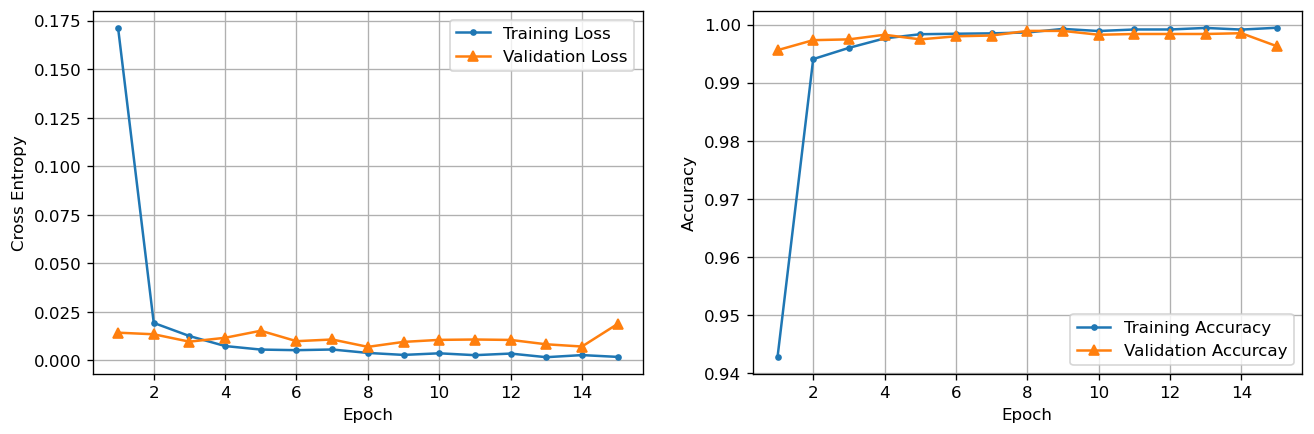

In [69]:
plot_training_curves(pd.DataFrame(history_2.history))

In [70]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [71]:
from sklearn import metrics

In [72]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [73]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 5s 43ms/step - loss: 0.0143 - accuracy: 0.9969
Test Loss:  0.014311093837022781
Test Accuracy:  0.9969333410263062


In [74]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       0.98      1.00      0.99      1253
     Basmati       1.00      1.00      1.00      1283
      Ipsala       1.00      1.00      1.00      1303
     Jasmine       1.00      1.00      1.00      1301
   Karacadag       1.00      0.98      0.99      1260

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# InceptionV3

In [75]:
from tensorflow.keras.applications import InceptionV3

In [76]:
inceptionV3Model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [77]:
inceptionV3Model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [78]:
inceptionV3Model.trainable = True

In [79]:
from tensorflow.keras import layers

In [80]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    inceptionV3Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [81]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [82]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 121s 121ms/step - loss: 0.2802 - accuracy: 0.9013 - val_loss: 0.0175 - val_accuracy: 0.9948
Epoch 2/15
937/937 [==============================] - 111s 118ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0114 - val_accuracy: 0.9975
Epoch 3/15
937/937 [==============================] - 110s 117ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0127 - val_accuracy: 0.9965
Epoch 4/15
937/937 [==============================] - 110s 117ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0096 - val_accuracy: 0.9973
Epoch 5/15
937/937 [==============================] - 109s 117ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.0103 - val_accuracy: 0.9973
Epoch 6/15
937/937 [==============================] - 108s 115ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0080 - val_accuracy: 0.9977
Epoch 7/15
937/937 [==============================] - 111s 118ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0083 -

In [83]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [84]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\inceptionV3Model.h5')

In [85]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

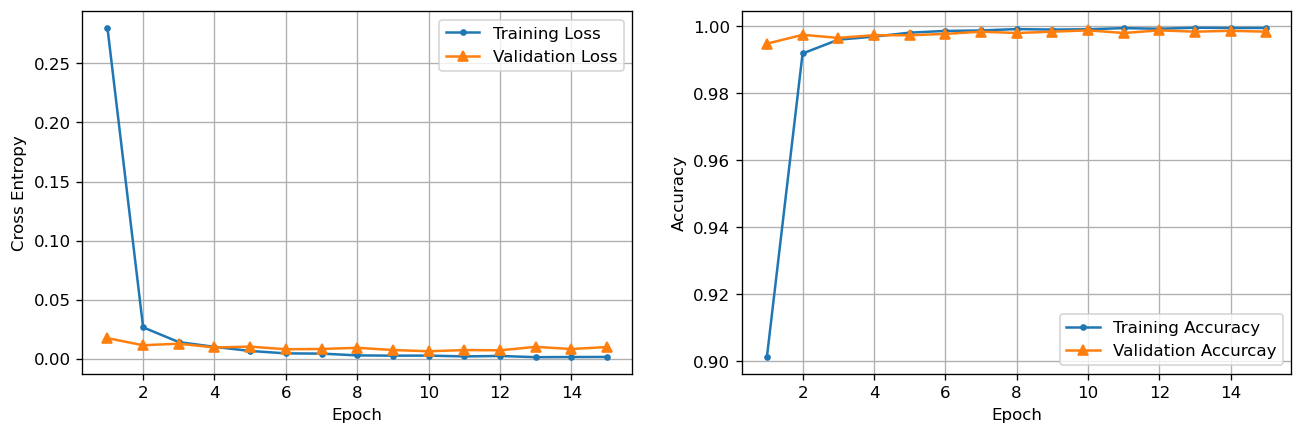

In [86]:
plot_training_curves(pd.DataFrame(history_2.history))

In [87]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [88]:
from sklearn import metrics

In [89]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [90]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 5s 40ms/step - loss: 0.0038 - accuracy: 0.9992
Test Loss:  0.0037794956006109715
Test Accuracy:  0.9991999864578247


In [91]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      1262
     Basmati       1.00      1.00      1.00      1260
      Ipsala       1.00      1.00      1.00      1316
     Jasmine       1.00      1.00      1.00      1300
   Karacadag       1.00      1.00      1.00      1262

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# MobileNetV2

In [92]:
from tensorflow.keras.applications import MobileNetV2

In [93]:
mobileNetV2Model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [94]:
mobileNetV2Model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [95]:
mobileNetV2Model.trainable = True

In [96]:
from tensorflow.keras import layers

In [97]:
tf.random.set_seed(42)

In [98]:
model2 = keras.Sequential([
    layers.Rescaling(1./255),
    mobileNetV2Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [99]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [100]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 103s 106ms/step - loss: 0.1718 - accuracy: 0.9409 - val_loss: 1.6487 - val_accuracy: 0.5482
Epoch 2/15
937/937 [==============================] - 99s 105ms/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 1.6195 - val_accuracy: 0.5684
Epoch 3/15
937/937 [==============================] - 98s 105ms/step - loss: 0.0183 - accuracy: 0.9941 - val_loss: 0.2371 - val_accuracy: 0.9174
Epoch 4/15
937/937 [==============================] - 99s 106ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0559 - val_accuracy: 0.9827
Epoch 5/15
937/937 [==============================] - 100s 107ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.0224 - val_accuracy: 0.9939
Epoch 6/15
937/937 [==============================] - 99s 106ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0121 - val_accuracy: 0.9963
Epoch 7/15
937/937 [==============================] - 100s 106ms/step - loss: 0.0052 - accuracy: 0.9982 - val_loss: 0.0075 - val

In [101]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              20972544  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)              

In [102]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\mobileNetV2Model.h5')

c:\Users\Shuvashis\anaconda3\envs\FAIKA\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [103]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

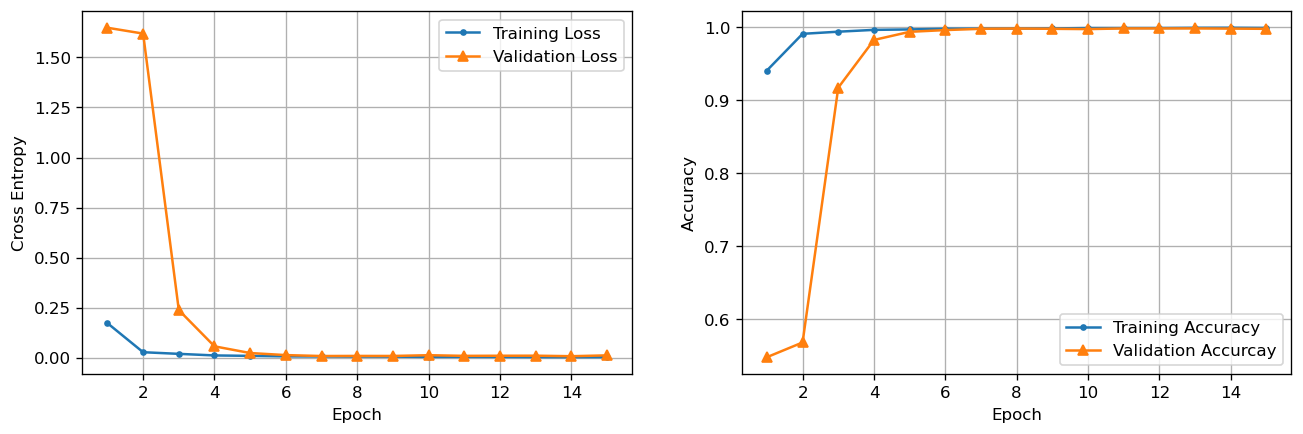

In [104]:
plot_training_curves(pd.DataFrame(history_2.history))

In [105]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [106]:
from sklearn import metrics

In [107]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [108]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 4s 31ms/step - loss: 0.0056 - accuracy: 0.9987
Test Loss:  0.0055684964172542095
Test Accuracy:  0.9986666440963745


In [109]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      1267
     Basmati       1.00      1.00      1.00      1278
      Ipsala       1.00      1.00      1.00      1307
     Jasmine       1.00      1.00      1.00      1313
   Karacadag       1.00      1.00      1.00      1235

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# Xception

In [12]:
from tensorflow.keras.applications import Xception

In [13]:
xceptionModel = Xception(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [14]:
xceptionModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [15]:
xceptionModel.trainable = True

In [16]:
from tensorflow.keras import layers

In [17]:
tf.random.set_seed(42)

model2 = keras.Sequential([
    layers.Rescaling(1./255),
    xceptionModel,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [18]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [19]:
history_2 = model2.fit(train_set, epochs=15, validation_data=val_set)

Epoch 1/15
937/937 [==============================] - 199s 204ms/step - loss: 0.1257 - accuracy: 0.9618 - val_loss: 0.0108 - val_accuracy: 0.9968
Epoch 2/15
937/937 [==============================] - 176s 188ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0058 - val_accuracy: 0.9984
Epoch 3/15
937/937 [==============================] - 188s 201ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0076 - val_accuracy: 0.9981
Epoch 4/15
937/937 [==============================] - 178s 190ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0066 - val_accuracy: 0.9984
Epoch 5/15
937/937 [==============================] - 180s 192ms/step - loss: 0.0034 - accuracy: 0.9987 - val_loss: 0.0048 - val_accuracy: 0.9989
Epoch 6/15
937/937 [==============================] - 180s 192ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9988
Epoch 7/15
937/937 [==============================] - 179s 191ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0072 -

In [20]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [21]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\xceptionModel.h5')

c:\Users\Shuvashis\anaconda3\envs\FAIKA\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

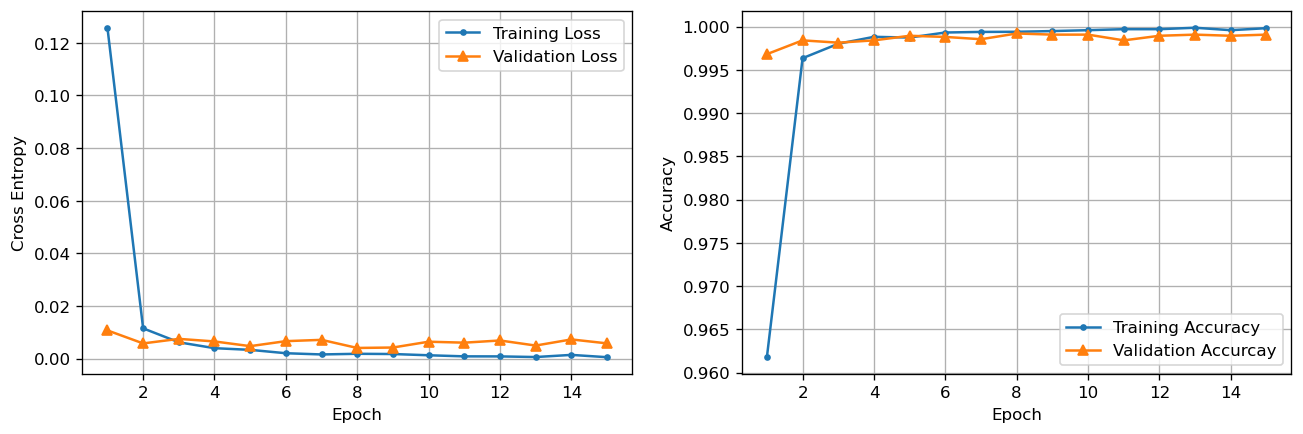

In [23]:
plot_training_curves(pd.DataFrame(history_2.history))

In [24]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

(TensorShape([6400, 128, 128, 3]), TensorShape([6400]))

In [25]:
from sklearn import metrics

In [26]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [27]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

118/118 [==============================] - 6s 46ms/step - loss: 0.0064 - accuracy: 0.9989
Test Loss:  0.006424376275390387
Test Accuracy:  0.9989333152770996


In [28]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00      1262
     Basmati       1.00      1.00      1.00      1275
      Ipsala       1.00      1.00      1.00      1309
     Jasmine       1.00      1.00      1.00      1298
   Karacadag       1.00      1.00      1.00      1256

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



# DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
denseNet201Model = DenseNet201(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))

In [ ]:
denseNet201Model.summary()

In [ ]:
denseNet201Model.trainable = True

In [ ]:
from tensorflow.keras import layers

In [ ]:
tf.random.set_seed(42)

In [ ]:
model2 = keras.Sequential([
    layers.Rescaling(1./255),
    denseNet201Model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model2.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer = keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
history_2 = model2.fit(train_set, epochs=25, validation_data=val_set)

In [ ]:
model2.summary()

In [ ]:
# Save the model
model2.save('d:\\Rice_Image_Dataset\\Model\\denseNet201Model.h5')

In [ ]:
def plot_training_curves(history_df):
    plt.figure(figsize = (13, 4), dpi = 120)
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
    plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '^', label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.grid()
    plt.legend()
    ax = plt.subplot(1, 2, 2) 
    plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '.', label = 'Training Accuracy')
    plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '^', label = 'Validation Accurcay')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
plot_training_curves(pd.DataFrame(history_2.history))

In [ ]:
X_test, y_test = None, None
for images, labels in test_data.take(100):
	if X_test == None or y_test == None:
		X_test = images
		y_test = labels
	else:
		X_test = tf.concat([X_test, images], axis = 0)
		y_test = tf.concat([y_test, labels], axis = 0)
	
X_test.shape, y_test.shape

In [ ]:
from sklearn import metrics

In [ ]:
y_pred_proba = model2.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

In [ ]:
test_score = model2.evaluate(test_data, verbose= 1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))